# Predicting survival of the Titanic sinking

This notebook is based on the [Data Science Tutorial](https://code.visualstudio.com/docs/datascience/data-science-tutorial) from the [Visual Studio Code documentation](https://code.visualstudio.com/docs). It uses the [Titanic dataset](https://hbiostat.org/data/repo/titanic.html) available on [OpenML.org](https://www.openml.org/d/40945), which is obtained from [Vanderbilt University's Department of Biostatistics](https://hbiostat.org/data/). The Titanic data provides information about the survival of passengers on the Titanic, as well as characteristics about the passengers such as age and ticket class. Using this data, the goal is to establish a model for predicting whether a given passenger would have survived the sinking of the Titanic.

## Setup

Import modules and set up global variables etc. for the notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense

plt.style.use('default')    # set plot style

## Preparing the data

We load the Titanic into a pandas dataframe and inspect the first few rows. The size of the dataset is about 115 KB small so it's no problem to load the whole dataset to memory.

In [2]:
data = pd.read_csv('titanic.csv')
data.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


Before the data can be graphed, we make sure that there aren't any issues with it. There are some missing values in the data. A question mark (`'?'`) was used to designate cells where data wasn't available. Pandas can read this value into a DataFrame, but the result for a column like `age` is that its data type will be set to `object` instead of a numeric data type, which is problematic for graphing.

This problem can be corrected by replacing the question mark with a missing value that pandas is able to understand, the numpy `NaN` value. We also need to update the column's data type after replacing the values.

In [3]:
data.replace('?', np.nan, inplace= True)
data = data.astype({"age": np.float64, "fare": np.float64})
data.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Analyzing the data

Now that the data is in good shape, you can use [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/) to view how certain columns of the dataset relate to survivability.

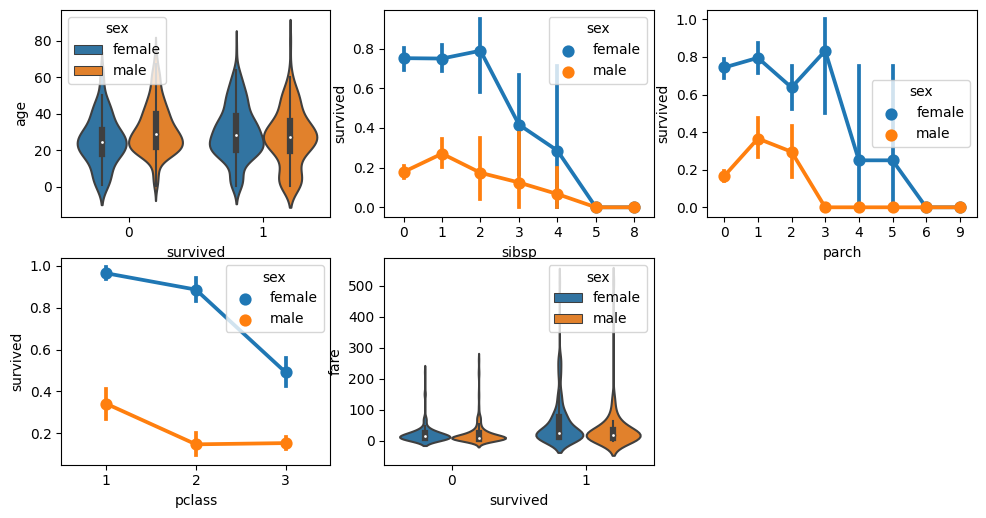

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30/2.54,15/2.54))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0, 0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[0, 1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[0, 2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[1, 0])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[1, 1])
axs[1, 2].axis('off') # hide 6th graph
plt.show()

These graphs are helpful in seeing some of the relationships between survival and the input variables of the data, but it's also possible to use `pandas` to calculate correlations. To do so, all the variables used need to be numeric for the correlation calculation and currently `gender` is stored as a `string`. We convert it to numeric.

In [5]:
data.replace({'male': 1, 'female': 0}, inplace=True)

Now, we can analyze the correlation between all the input variables to identify the features that would be the best inputs to a machine learning model. The closer a value is to 1, the higher the correlation between the value and the result.

In [6]:
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265


Looking at the correlation results, we notice that some variables like `gender` have a fairly high correlation to `survival`, while others like relatives (`sibsp` = siblings or spouse, `parch` = parents or children) seem to have little correlation.

Let's hypothesize that `sibsp` and `parch` are related in how they affect survivability, and group them into a new column called `relatives` to see whether the combination of them has a higher correlation to survivability. To do this, we check if for a given passenger, the number of sibsp and parch is greater than 0 and, if so, you can then say that they had a relative on board.

In [7]:
data['relatives'] = data.apply(lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265
relatives,0.201719


In fact when looked at from the standpoint of whether a person had relatives, versus how many relatives, there is a higher correlation with survival. With this information in hand, we can now drop from the dataset the low value `sibsp` and `parch` columns, as well as any rows that had `NaN` values, to end up with a dataset that can be used for training a model. Although `age` has a low direct correlation, it is kept because it seems reasonable that it might still have correlation in conjunction with other inputs.

In [8]:
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()

## Training and evaluating a model

With the dataset ready, we can now begin creating a model. We use the `scikit-learn` library (as it offers some useful helper functions) to do pre-processing of the dataset, train a classification model to determine survivability on the Titanic, and then use that model with test data to determine its accuracy.

A common first step to training a model is to divide up the dataset into training and validation data. This allows you to use a portion of the data to train the model and a portion of the data to test the model. If you used all your data to train the model, you wouldn't have a way to estimate how well it would actually perform against data the model has not yet seen. A benefit of the `scikit-learn` library is that it provides a method specifically for splitting a dataset into training and test data.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

Next, we normalize the inputs such that all features are treated equally. For example, within the dataset the values for `age` range from `~0-100`, while `gender` is only a `1` or `0`. By normalizing all the variables, we can ensure that the ranges of values are all the same.

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

### Model based on the Naïve Bayes algorithm

There are a number of different machine learning algorithms that we could choose from to model the data and scikit-learn provides support for a number of [them](https://scikit-learn.org/stable/user_guide.html), as well as a [chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to help select the one that's right for our scenario. For now, we use the [Naïve Bayes algorithm](https://scikit-learn.org/stable/modules/naive_bayes.html), a common algorithm for classification problems.

In [11]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

With a trained model, we can now try it against the test data set that was held back from training. We run the following code to predict the outcome of the test data and calculate the accuracy of the model.

In [12]:
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885


Looking at the result of the test data, we see that the trained algorithm had a ~75% success rate at estimating survival.

### Model based on a neural network

We can try to increase accuracy using a neural network. A neural network is a model that uses weights and activation functions, modeling aspects of human neurons, to determine an outcome based on provided inputs. Unlike the machine learning algorithm we used previously, neural networks are a form of deep learning wherein we don't need to know an ideal algorithm for our problem set ahead of time. It can be used for many different scenarios and classification is one of them. For this section, we use the `Keras` library with `TensorFlow` to construct the neural network, and explore how it handles the Titanic dataset.

The first step is to import the required libraries and to create the model. In this case, we use a [Sequential](https://keras.io/getting-started/sequential-model-guide/) neural network, which is a layered neural network wherein there are multiple layers that feed into each other in sequence.

In [13]:
model = Sequential()

After defining the model, the next step is to add the layers of the neural network. For now, let's keep things simple and just use three layers.

In [14]:
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))


The first layer will be set to have a dimension of 5, since we have 5 inputs: sex, pclass, age, relatives, and fare.
The last layer must output 1, since we want a 1-dimensional output indicating whether a passenger would survive.
The middle layer was kept at 5 for simplicity, although that value could have been different.

The rectified linear unit (relu) activation function is used as a good general activation function for the first two layers, while the sigmoid activation function is required for the final layer as the output we want (of whether a passenger survives or not) needs to be scaled in the range of 0-1 (the probability of a passenger surviving).

We can also look at the summary of the model we built:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


Once the model is created, it needs to be compiled. As part of this, we need to define what type of optimizer will be used, how loss will be calculated, and what metric should be optimized for. The following code builds and trains the model:

In [16]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
27/27 [==============================] - 0s 731us/step - loss: 0.6924 - accuracy: 0.5885
Epoch 2/50
27/27 [==============================] - 0s 139us/step - loss: 0.6897 - accuracy: 0.5861
Epoch 3/50
27/27 [==============================] - 0s 711us/step - loss: 0.6849 - accuracy: 0.5861
Epoch 4/50
27/27 [==============================] - 0s 41us/step - loss: 0.6751 - accuracy: 0.6579
Epoch 5/50
27/27 [==============================] - 0s 88us/step - loss: 0.6571 - accuracy: 0.7512
Epoch 6/50
27/27 [==============================] - 0s 604us/step - loss: 0.6298 - accuracy: 0.7632
Epoch 7/50
27/27 [==============================] - 0s 127us/step - loss: 0.5975 - accuracy: 0.7703
Epoch 8/50
27/27 [==============================] - 0s 105us/step - loss: 0.5634 - accuracy: 0.7727
Epoch 9/50
27/27 [==============================] - 0s 654us/step - loss: 0.5359 - accuracy: 0.7751
Epoch 10/50
27/27 [==============================] - 0s 615us/step - loss: 0.5125 - accuracy: 0.7763
E

We notice that after training the accuracy is ~80%. With the model built and trained its now time to see how it performs against the test data.

In [17]:
# model.predict() is deprecated
# use np.argmax(model.predict(x), axis=-1) for multi-class classification
# use (model.predict(x) > 0.5).astype("int32") for binary classification
#y_pred = model.predict(X_test)

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(metrics.accuracy_score(y_test, y_pred))

0.7990430622009569


Similar to the training, we notice that we were able to get close to 80% accuracy in predicting survival of passengers. This result was better than the 75% accuracy from the Naive Bayes Classifier tried previously.

In [18]:
print("""Predicting a person
sex: male
passenger class: 0
age: 34
relatives: 3
fare: 10 $""")

x_test = pd.DataFrame(
    np.array([[1, 0, 33, 3, 10]]),
    columns=['sex', 'pclass', 'age','relatives', 'fare']
)
y_pred = (model.predict(sc.transform(x_test)) > 0.5).astype("int32")
if(y_pred[0] == 0):
    print("Prediction: This person would have died.")
else:
    print("Prediction: This person would have survived.")

Predicting a person
sex: male
passenger class: 0
age: 34
relatives: 3
fare: 10 $
Prediction: This person would have survived.
